### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

### Loading the data

In [4]:
official_names = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride']

In [5]:
components = np.loadtxt('metabolity.csv', delimiter=',', skiprows=1)
ppm_components = components[:,0]
components = components[:,1:]

mix = np.loadtxt('mieszanina_metabolitow.csv', delimiter=',', skiprows=1)
ppm = mix[:,0]
mix = mix[:,1]

In [6]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [7]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [8]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [9]:
mix = Spectrum(confs=list(zip(ppm,mix)))

### Additional preprocessing: removing peak from solvent

In [10]:
def remove_peak_from_region(spectrum, region):
    
    lower_bound = region[0]
    upper_bound = region[1]
    
    new_confs = np.array(spectrum.confs)
    in_region = np.logical_and(lower_bound < new_confs[:,0], new_confs[:,0] < upper_bound)
    new_confs[in_region, 1] = 0
    
    return Spectrum(confs=list(zip(new_confs[:,0], new_confs[:,1])))

In [11]:
preprocessed_spectra = []
for sp in [mix] + spectra:
    no_solvent_peak = remove_peak_from_region(sp, (4.4, 4.8))
    no_solvent_peak.normalize()
    preprocessed_spectra.append(no_solvent_peak)
mix = preprocessed_spectra[0]
spectra = preprocessed_spectra[1:]
del(preprocessed_spectra)

### Alignment

In [12]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [13]:
#shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
mix = shift_one_spectrum(mix, -0.14)

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
spectra_and_mixture = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
# mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True) 
# comp2.plot(profile=True)
# comp3.plot(profile=True)
# comp4.plot(profile=True)

### Removing unnecessary data points

In [27]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [28]:
#3.2, 6.5
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.2, 6.5)

In [29]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [30]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [31]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [32]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [33]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [34]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [35]:
labels = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride', 'Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

In [36]:
comp0.label

'Lactate'

<IPython.core.display.Javascript object>


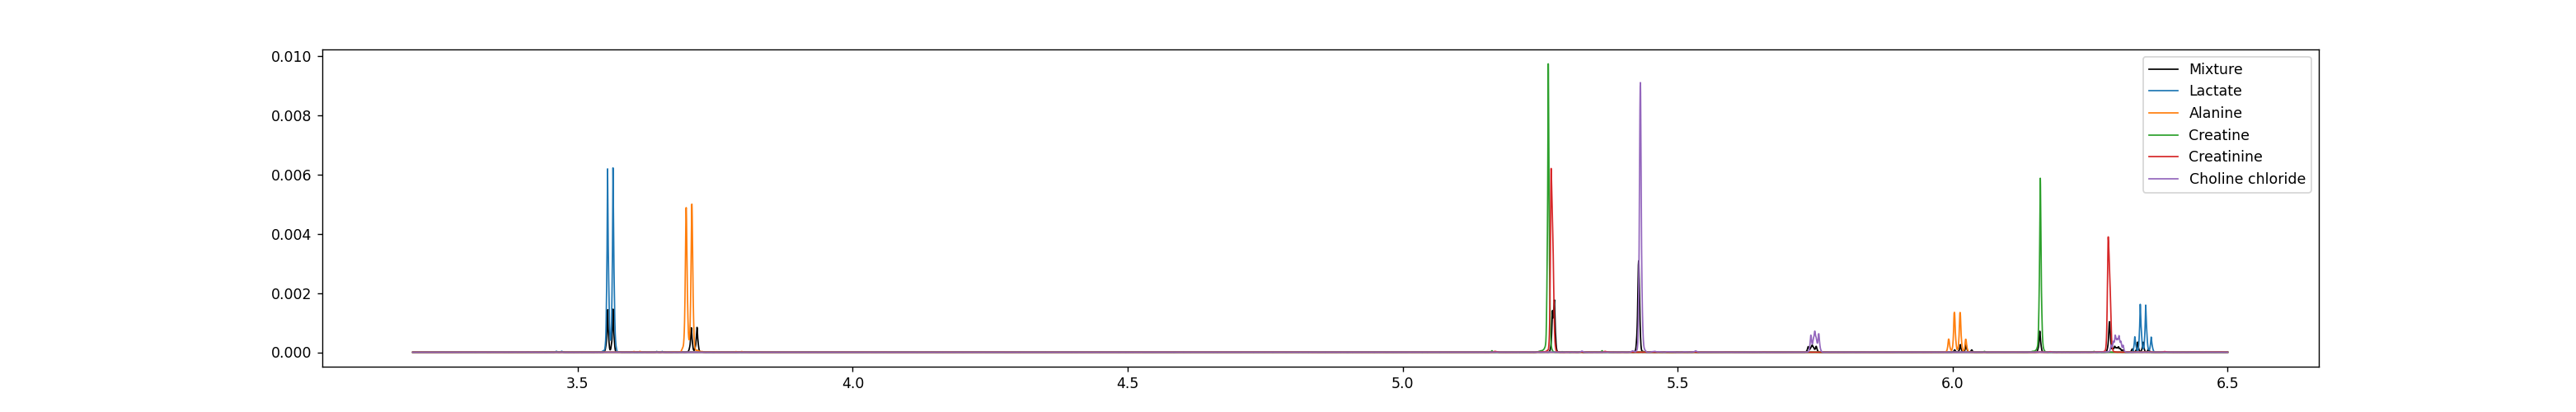

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)
ax.legend()
#plt.savefig('aligned_spectra.png', dpi=300)

### Estimation

In [38]:
estimation = estimate_proportions(mix, spectra, 
                                   MTD=0.1, MTD_th=0.1, verbose=False, solver=pulp.GUROBI())

Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 230456.26it/s]
Splitting the experimental spectrum into chunks: 54258it [00:00, 3534589.52it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 217034 rows, 54261 columns and 626520 nonzeros
Model fingerprint: 0xf3dd0469
Coefficient statistics:
  Matrix range     [9e-13, 1e+00]
  Objective range  [9e-13, 1e+00]
  Bounds range     [2e-05, 2e-05]
  RHS range        [2e-05, 1e-01]
Presolve removed 11350 rows and 0 columns (presolve time = 5s) ...
Presolve removed 19581 rows and 0 columns (presolve time = 10s) ...
Presolve removed 71464 rows and 0 columns
Presolve time: 30.66s
Presolved: 54261 rows, 217033 columns, 626519 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barri

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:43<00:00, 43.53s/it]


In [39]:
estimation['proportion_of_noise_in_theoretical']

0.019582643265999903

In [40]:
p = estimation['proportions']
p

[0.2276933530719989,
 0.15070816371299925,
 0.11570424221499943,
 0.18051160003299913,
 0.32538264096699837]

### Ground truth

In [41]:
protons = [4, 4, 5, 5, 13]

In [42]:
# Lactate: 0.3022;
# Alanine: 0.2240;
# Creatine: 0.1253;
# Creatinine: 0.2028;
# Choline chloride: 0.1457.

### Our estimation vs ground truth

In [43]:
molar_proportions = [prop/prot for prop, prot in zip(p, protons)]
molar_proportions = list(molar_proportions/sum(molar_proportions))
molar_proportions

[0.3182332947632619,
 0.21063572932207328,
 0.1293702840996772,
 0.2018321587220856,
 0.13992853309290215]

### Visualisation of our estimation

In [43]:
p = np.array(p).reshape(len(p),1)

In [44]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [45]:
components_ints = [comp_int.reshape(-1, 1) for comp_int in components_ints]

In [46]:
X = np.concatenate(components_ints, axis=1)

In [47]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


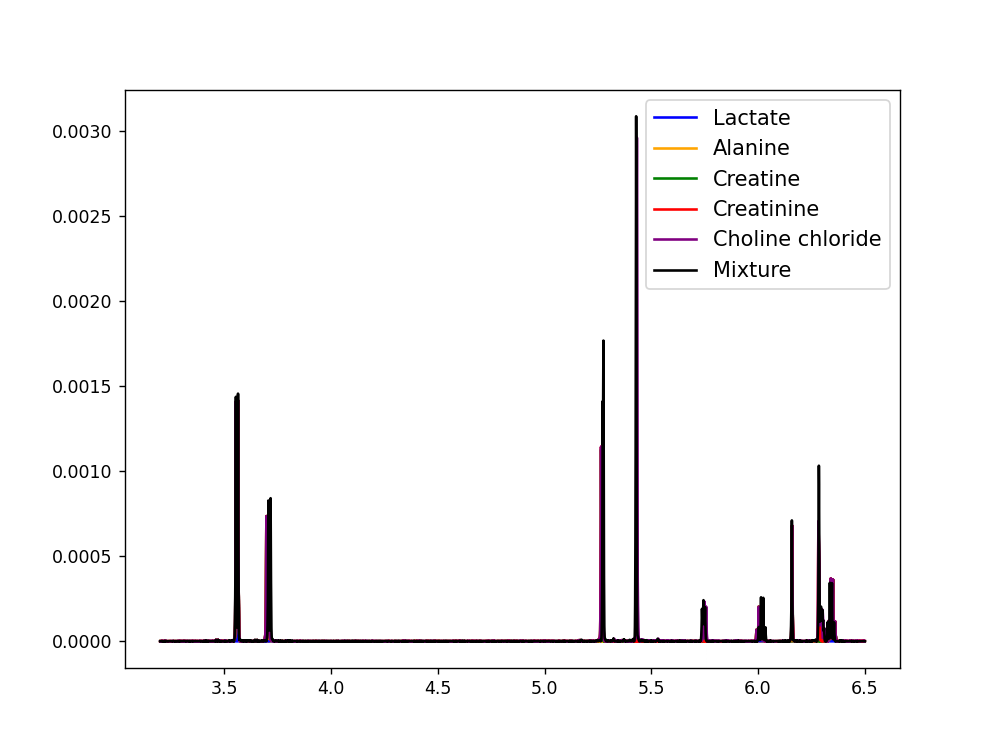

In [49]:
colors = ['blue', 'orange', 'green', 'red', 'purple']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture')
ax.legend(prop={'size': 12})